In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel

import plotly.figure_factory as ff

import graphviz
import pydotplus


In [ ]:
def null_fill(data): #Function to full the null value in the data set
  null_replace = {'children':0.0,
                  'babies':0.0,
                  'country':0.0,
                  'agent':0.0,
                  'company':0.0}
  data.fillna(null_replace, inplace = True)
url = 'https://drive.google.com/file/d/1Zqh_fhxlI5bc8pYEaUx36bnhEP-7bypD/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
hotel_data = pd.read_csv(path)
hotel_data.head() #Dataset Preview
hotel_data.info()

def null_check(data): #Function to check all the null value in the data set
  check = data.isnull().sum()[data.isnull().sum()!=0]
  if check.empty :
    print("No Null value in the data set")
  else:
    print("The data set contain null value")
    print(check)

null_check(hotel_data) #Show all null value in the data set
null_fill(hotel_data)
null_check(hotel_data)
#### Handling adnormal data
hotel_data['children']=hotel_data['children'].astype(int)
zero_guest = list(hotel_data.loc[hotel_data['adults']+hotel_data['children']+hotel_data['babies']==0].index)
hotel_data.drop(hotel_data.index[zero_guest],inplace=True)
zero_adr = list(hotel_data.loc[hotel_data['adr']==0].index)
hotel_data.drop(hotel_data.index[zero_adr],inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

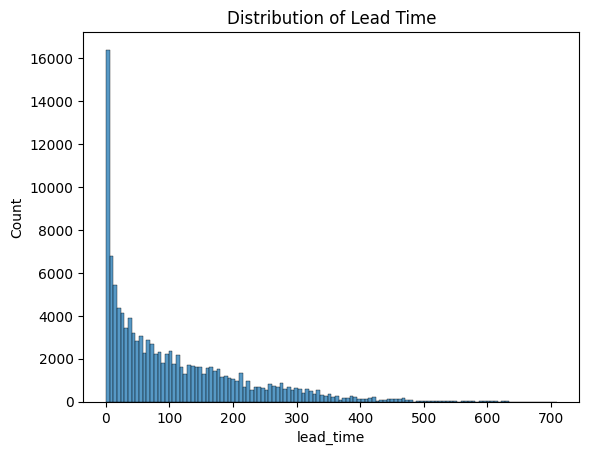

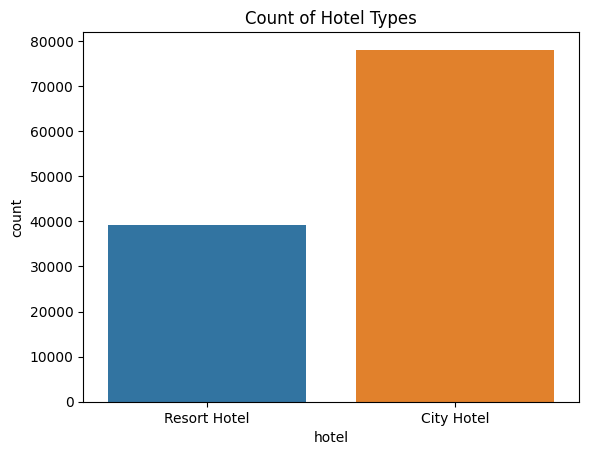

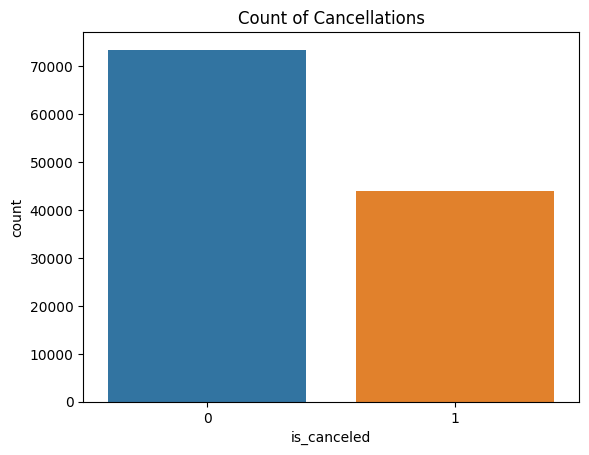

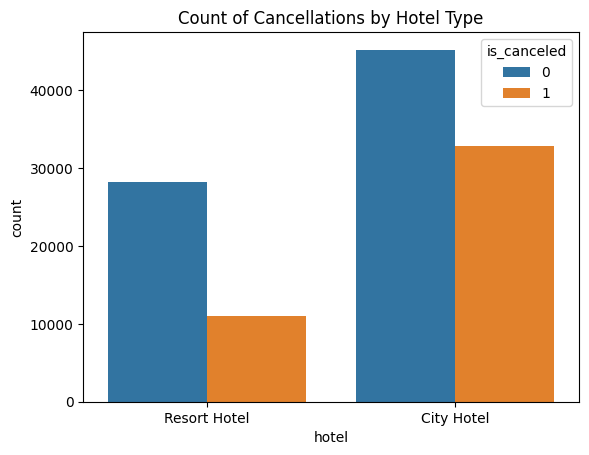

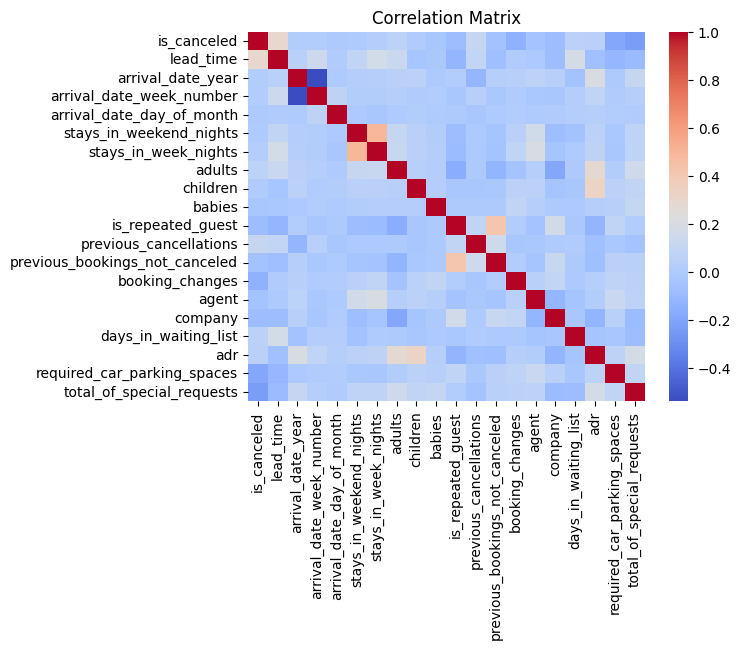

In [ ]:
### EDA
# Plot the distribution of a numerical variable
sns.histplot(data=hotel_data, x='lead_time')
plt.title('Distribution of Lead Time')
plt.show()

# Plot the count of a categorical variable
sns.countplot(data=hotel_data, x='hotel')
plt.title('Count of Hotel Types')
plt.show()

# Plot the count of the is_canceled variable
sns.countplot(data=hotel_data, x='is_canceled')
plt.title('Count of Cancellations')
plt.show()

# Plot the count of the is_canceled variable grouped by the hotel variable
sns.countplot(data=hotel_data, x='hotel', hue='is_canceled')
plt.title('Count of Cancellations by Hotel Type')
plt.show()

# Plot the correlation matrix of numerical variables
corr = hotel_data.corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Data Preprocessing, Feature Transformation

In [ ]:
#### Data Preprocessing, Feature Transformation
#### Dropping the unrelated column for decision tree
useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
'reservation_status', 'country', 'days_in_waiting_list']
df = hotel_data.copy()
df.drop(useless_col, axis = 1, inplace = True)


#### Data Transformation
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_df = df[cat_cols]
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

cat_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['market_segment'] = cat_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['distribution_channel'] = cat_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

cat_df['deposit_type'] = cat_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['customer_type'] = cat_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

num_df = df.drop(columns = cat_cols, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)

X = pd.concat([cat_df, num_df], axis = 1)
y = df['is_canceled']
X.shape, y.shape


#### Train Test Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=80)


#Logistics Regression

Test accuracy of the logistic regression model: 0.81
Train accuracy of the logistic regression model: 0.82


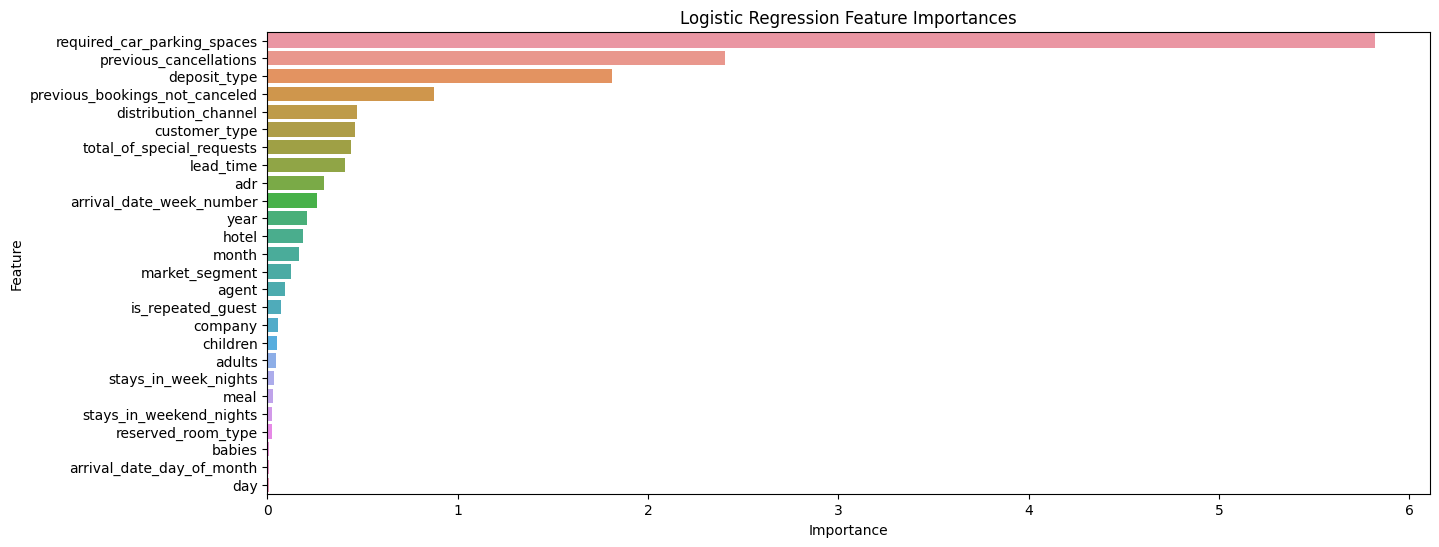

Test accuracy of L1 regularization: 0.81
Train accuracy of L1 regularization: 0.82
Test accuracy of L2 regularization with GridSearchCV: 0.81
Train accuracy of L2 regularization with GridSearchCV: 0.82


In [ ]:
####Logistics Regression
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test sets
num_cols = num_df.columns
X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler.transform(X_test[num_cols])

# Replace the original numerical columns with the scaled ones
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = X_train_num_scaled
X_test_scaled[num_cols] = X_test_num_scaled

# Instantiate the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
test_accuracy = log_reg.score(X_test_scaled, y_test)
train_accuracy_log_reg = log_reg.score(X_train_scaled, y_train)
print(f"Test accuracy of the logistic regression model: {test_accuracy:.2f}")
print(f"Train accuracy of the logistic regression model: {train_accuracy_log_reg:.2f}")

# Get the coefficients from the logistic regression model
coef = log_reg.coef_[0]

# Calculate the importance of each feature
importance = np.abs(coef)

# Create a DataFrame containing feature names and their importance
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Create a bar plot of the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importances')
plt.show()

# Feature Selection
sel = SelectFromModel(LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', random_state=42))
X_train_sel = sel.fit_transform(X_train_scaled, y_train)
X_test_sel = sel.transform(X_test_scaled)

# L1 Regularization
log_reg_l1 = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=1000, random_state=42).fit(X_train_sel, y_train)

test_accuracy_l1 = log_reg_l1.score(X_test_sel, y_test)
train_accuracy_l1 = log_reg_l1.score(X_train_sel, y_train)

# L2 Regularization with GridSearchCV
param_grid_l2 = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_l2 = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs', random_state=42)
grid_search_l2 = GridSearchCV(log_reg_l2, param_grid_l2, cv=5)
grid_search_l2.fit(X_train_sel, y_train)

test_accuracy_l2 = grid_search_l2.score(X_test_sel, y_test)
train_accuracy_l2 = grid_search_l2.score(X_train_sel, y_train)

print(f"Test accuracy of L1 regularization: {test_accuracy_l1:.2f}")
print(f"Train accuracy of L1 regularization: {train_accuracy_l1:.2f}")
print(f"Test accuracy of L2 regularization with GridSearchCV: {test_accuracy_l2:.2f}")
print(f"Train accuracy of L2 regularization with GridSearchCV: {train_accuracy_l2:.2f}")


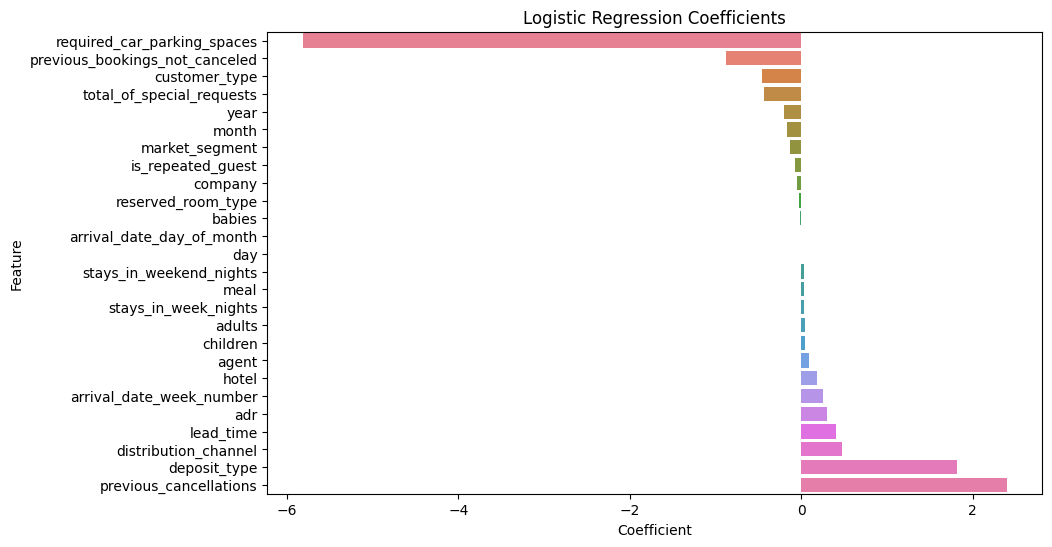

In [ ]:
# Get the coefficients of the logistic regression model
coef = log_reg.coef_[0]

# Get the feature names
features = X_train_scaled.columns

# Create a dataframe of the coefficients and their corresponding feature names
coef_df = pd.DataFrame({'feature': features, 'coefficient': coef})

# Sort the coefficients in descending order and plot them as a horizontal bar plot
coef_df_sorted = coef_df.sort_values('coefficient', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=coef_df_sorted, palette='husl')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()


In [ ]:
# k-fold cross-validation on Logistic Regression
# Perform k-fold cross-validation with 5 folds
cv_scores = cross_val_score(log_reg_l2, X_train_scaled, y_train, cv=5)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold of L2 regularization :", cv_scores)

# Calculate and print the average accuracy across the 5-fold cross-validation
average_accuracy = cv_scores.mean()
print(f"Average accuracy across the 5-fold cross-validation of L2 regularization: {average_accuracy:.2f}")

# Perform k-fold cross-validation with 5 folds
cv_scores = cross_val_score(log_reg_l1, X_train_scaled, y_train, cv=5)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold of L1 regularization:", cv_scores)

# Calculate and print the average accuracy across the 5-fold cross-validation
average_accuracy = cv_scores.mean()
print(f"Average accuracy across the 5-fold cross-validation of L1 regularization: {average_accuracy:.2f}")

Accuracy scores for each fold of L2 regularization : [0.8204551  0.81710879 0.81084205 0.81692626 0.80877342]
Average accuracy across the 5-fold cross-validation of L2 regularization: 0.81
Accuracy scores for each fold of L1 regularization: [0.82063762 0.81747384 0.81108542 0.81723047 0.80877342]
Average accuracy across the 5-fold cross-validation of L1 regularization: 0.82


#Tree-based models

### Decision Tree

In [ ]:
# Instantiate the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree model on the training data
dt.fit(X_train, y_train)

# Evaluate the Decision Tree model on the test data
test_accuracy_dt = dt.score(X_test, y_test)
train_accuracy_dt = dt.score(X_train, y_train)
print(f"Test accuracy of the Decision Tree model: {test_accuracy_dt:.2f}")
print(f"Train accuracy of the Decision Tree model: {train_accuracy_dt:.2f}")
# The accuracy shows that the model is overfitting

Test accuracy of the Decision Tree model: 0.94
Train accuracy of the Decision Tree model: 1.00


In [ ]:
# Use k-fold cross-validation to evaluate the performance
k = 5
cv_scores = cross_val_score(dt, X, y, cv=k, scoring='accuracy')

# Calculate the average accuracy across the folds
average_accuracy = cv_scores.mean()

# Print the individual fold scores and the average accuracy
print(f"Accuracy scores for each fold: {cv_scores}")
print(f"Average accuracy across the {k}-fold cross-validation: {average_accuracy:.2f}")

Accuracy scores for each fold: [0.48441227 0.52091141 0.30873083 0.39459114 0.54246167]
Average accuracy across the 5-fold cross-validation: 0.45


In [ ]:
# Perform hyperparameter tuning with GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the decision tree model with the best hyperparameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

# Evaluate the model on the test data
test_accuracy_best_dt = best_dt.score(X_test, y_test)
train_accuracy_best_dt = best_dt.score(X_train, y_train)
print(f"Test accuracy of the Decision Tree model after grid search: {test_accuracy_best_dt:.2f}")
print(f"Train accuracy of the Decision Tree model after grid search: {train_accuracy_best_dt:.2f}")
# The overfitting is still existing, but the accuracy is better

Test accuracy of the Decision Tree model after grid search: 0.96
Train accuracy of the Decision Tree model after grid search: 0.99


In [ ]:
# Use k-fold cross-validation to evaluate the performance of best param
k = 5
cv_scores = cross_val_score(best_dt, X, y, cv=k, scoring='accuracy')

# Calculate the average accuracy across the folds
average_accuracy = cv_scores.mean()

# Print the individual fold scores and the average accuracy
print(f"Accuracy scores for each fold: {cv_scores}")
print(f"Average accuracy across the {k}-fold cross-validation: {average_accuracy:.2f}")

Accuracy scores for each fold: [0.52840716 0.53045145 0.32018739 0.38483816 0.57184838]
Average accuracy across the 5-fold cross-validation: 0.47


Test accuracy of the Decision Tree model: 0.94
Train accuracy of the Decision Tree model: 1.00


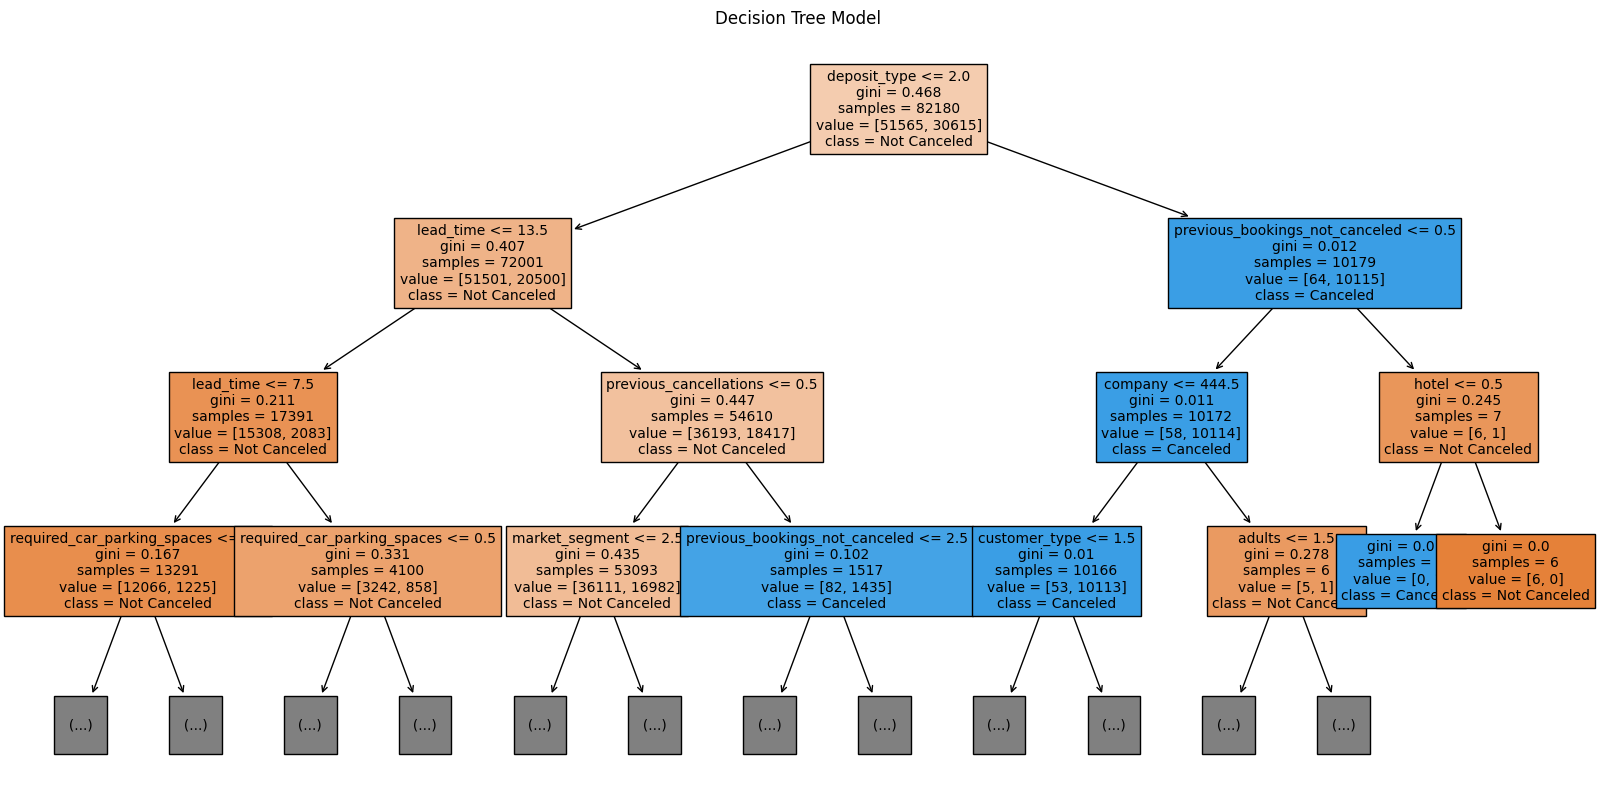

In [ ]:
#Visualize the plot
# Instantiate the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree model on the training data
dt.fit(X_train, y_train)

# Evaluate the Decision Tree model on the test data
test_accuracy_dt = dt.score(X_test, y_test)
train_accuracy_dt = dt.score(X_train, y_train)
print(f"Test accuracy of the Decision Tree model: {test_accuracy_dt:.2f}")
print(f"Train accuracy of the Decision Tree model: {train_accuracy_dt:.2f}")
# The accuracy shows that the model is overfitting

# Visualize the Decision Tree model
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['Not Canceled', 'Canceled'], max_depth=3, fontsize=10) #Max depth set to 3 for better readability
plt.title("Decision Tree Model")
plt.show()


### Random Forest

In [ ]:
####Random Forest
# Instantiate the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Evaluate the model on the test data
y_test_pred = rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred)

# Evaluate the model on the training data
y_train_pred = rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred)

print(f"Test accuracy of the Random Forest model: {test_accuracy_rf:.2f}")
print(f"Train accuracy of the Random Forest model: {train_accuracy_rf:.2f}")
#The model is overfitting

Test accuracy of the Random Forest model: 0.95
Train accuracy of the Random Forest model: 1.00


In [ ]:
# Use k-fold cross-validation to evaluate the performance
k = 5
cv_scores = cross_val_score(rf, X, y, cv=k, scoring='accuracy')

# Calculate the average accuracy across the folds
average_accuracy = cv_scores.mean()

# Print the individual fold scores and the average accuracy
print(f"Accuracy scores for each fold: {cv_scores}")
print(f"Average accuracy across the {k}-fold cross-validation: {average_accuracy:.2f}")


Accuracy scores for each fold: [0.67546848 0.5859029  0.34080068 0.38283646 0.61588586]
Average accuracy across the 5-fold cross-validation: 0.52


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the Random Forest model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the enhanced model on the test data
test_accuracy_best_rf = accuracy_score(y_test, best_rf.predict(X_test))
print(f"Test accuracy of the Random Forest model after grid search: {test_accuracy_best_rf:.2f}")

# Evaluate the enhanced model on the training data
train_accuracy_best_rf = accuracy_score(y_train, best_rf.predict(X_train))
print(f"Train accuracy of the Random Forest model after grid search: {train_accuracy_best_rf:.2f}")

Test accuracy of the Random Forest model after grid search: 0.95
Train accuracy of the Random Forest model after grid search: 1.00


In [ ]:
# Use k-fold cross-validation to evaluate the performance of best param
k = 5
cv_scores = cross_val_score(best_rf, X, y, cv=k, scoring='accuracy')

# Calculate the average accuracy across the folds
average_accuracy = cv_scores.mean()

# Print the individual fold scores and the average accuracy
print(f"Accuracy scores for each fold: {cv_scores}")
print(f"Average accuracy across the {k}-fold cross-validation: {average_accuracy:.2f}")

Accuracy scores for each fold: [0.67546848 0.5859029  0.34080068 0.38283646 0.61588586]
Average accuracy across the 5-fold cross-validation: 0.52


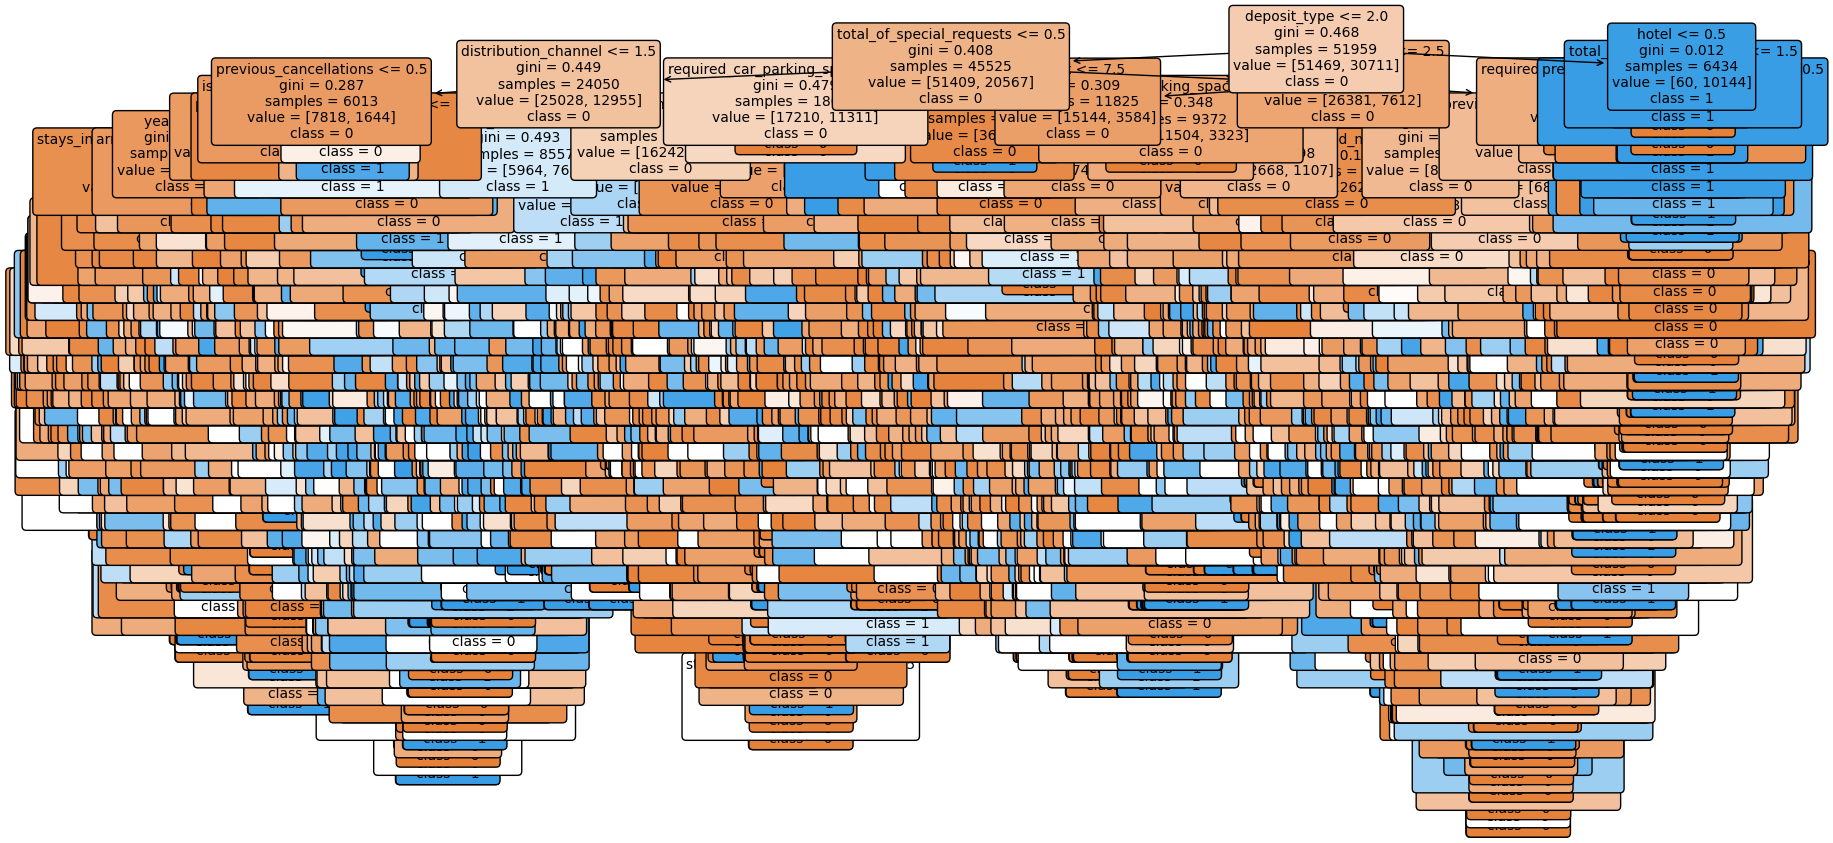

In [ ]:
# Random forest plotting
# Select one of the decision trees from the Random Forest
single_tree = best_rf.estimators_[0]

# Set the figure size
plt.figure(figsize=(20, 10))

# Visualize the selected decision tree
plot_tree(single_tree, feature_names=X.columns, class_names=["0", "1"], filled=True, rounded=True, fontsize=10)

# Show the plot
plt.show()

### Gradient Boosting

In [ ]:
# Instantiate the Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
gb.fit(X_train, y_train)

# Evaluate the model on the test data
test_accuracy_gb = gb.score(X_test, y_test)
train_accuracy_gb = gb.score(X_train, y_train)
print(f"Test accuracy of the Gradient Boosting model: {test_accuracy_gb:.2f}")
print(f"Train accuracy of the Gradient Boosting model: {train_accuracy_gb:.2f}")
# Random forest have a better accuracy but more overfit than the gradient boosting model

Test accuracy of the Gradient Boosting model: 0.92
Train accuracy of the Gradient Boosting model: 0.92


In [ ]:
# Perform k-fold cross-validation with 5 folds
cv_scores = cross_val_score(gb, X,y, cv=5)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", cv_scores)

# Calculate and print the average accuracy across the 5-fold cross-validation
average_accuracy = cv_scores.mean()
print(f"Average accuracy across the 5-fold cross-validation: {average_accuracy:.2f}")


Accuracy scores for each fold: [0.79080068 0.67546848 0.710477   0.67602215 0.72470187]
Average accuracy across the 5-fold cross-validation: 0.72


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the Gradient Boosting model with the best hyperparameters
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [ ]:
best_gb = GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=10,min_samples_split=10)

In [ ]:
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [ ]:
# Evaluate the enhanced model on the test data
test_accuracy_best_gb = accuracy_score(y_test, best_gb.predict(X_test))
print(f"Test accuracy of the Gradient Boosting model after grid search: {test_accuracy_best_gb:.5f}")

# Evaluate the enhanced model on the training data
train_accuracy_best_gb = accuracy_score(y_train, best_gb.predict(X_train))
print(f"Train accuracy of the Gradient Boosting model after grid search: {train_accuracy_best_gb:.5f}")

Test accuracy of the Gradient Boosting model after grid search: 0.99583
Train accuracy of the Gradient Boosting model after grid search: 0.99981


In [ ]:
# Use k-fold cross-validation to evaluate the performance of best param
k = 5
cv_scores = cross_val_score(best_gb, X, y, cv=k, scoring='accuracy')

# Calculate the average accuracy across the folds
average_accuracy = cv_scores.mean()

# Print the individual fold scores and the average accuracy
print(f"Accuracy scores for each fold: {cv_scores}")
print(f"Average accuracy across the {k}-fold cross-validation: {average_accuracy:.2f}")

Accuracy scores for each fold: [0.90310903 0.97653322 0.93977853 0.97333901 0.96763203]
Average accuracy across the 5-fold cross-validation: 0.95


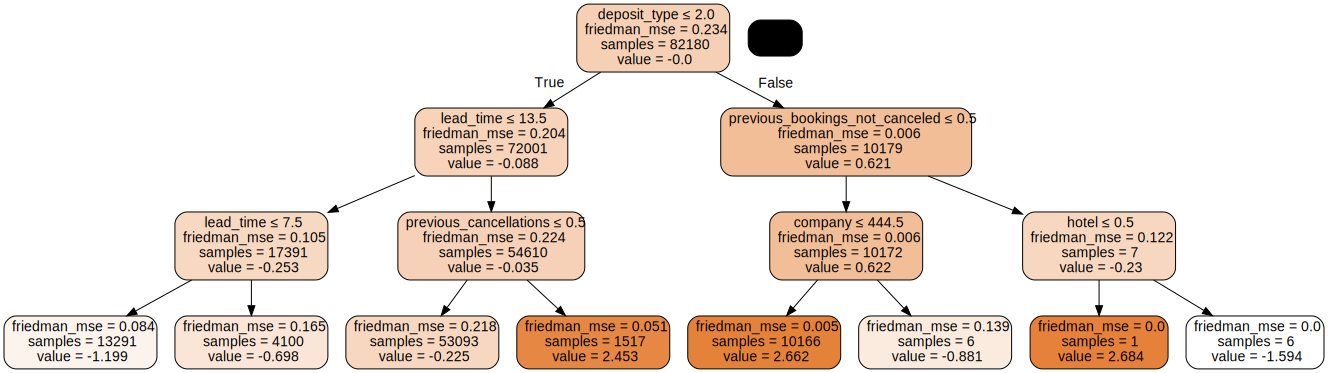

In [ ]:
# Function to plot a specific tree from the Gradient Boosting model
def plot_gradient_boosting_tree(gb_model, tree_index):
    sub_tree = gb_model.estimators_[tree_index, 0]
    dot_data = export_graphviz(
        sub_tree,
        out_file=None,
        feature_names=X_train.columns,
        class_names=['Not Canceled', 'Canceled'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    return graphviz.Source(graph.to_string())

# Plot a specific tree (e.g., the first tree) from the Gradient Boosting model
tree_to_plot = 0
plot_gradient_boosting_tree(gb, tree_to_plot)


###  Compare 3 models generaliztion performance

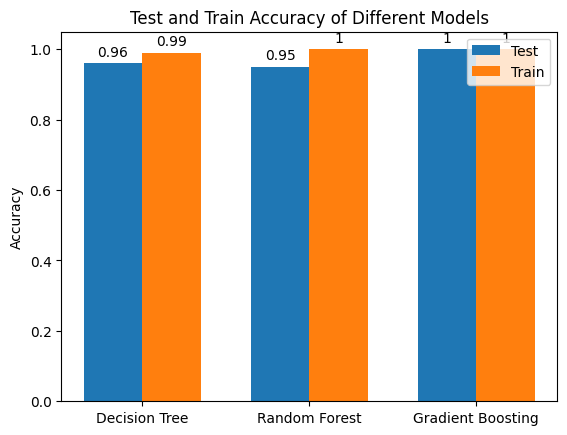

In [ ]:
#Visulization for comparing the accuracy of enhanced models
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
test_accuracies = [0.96, 0.95, 1.00]
train_accuracies = [00.99, 1.00, 1.00]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test')
rects2 = ax.bar(x + width/2, train_accuracies, width, label='Train')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Test and Train Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)


plt.show()

### Choose Gradient Boosting finally

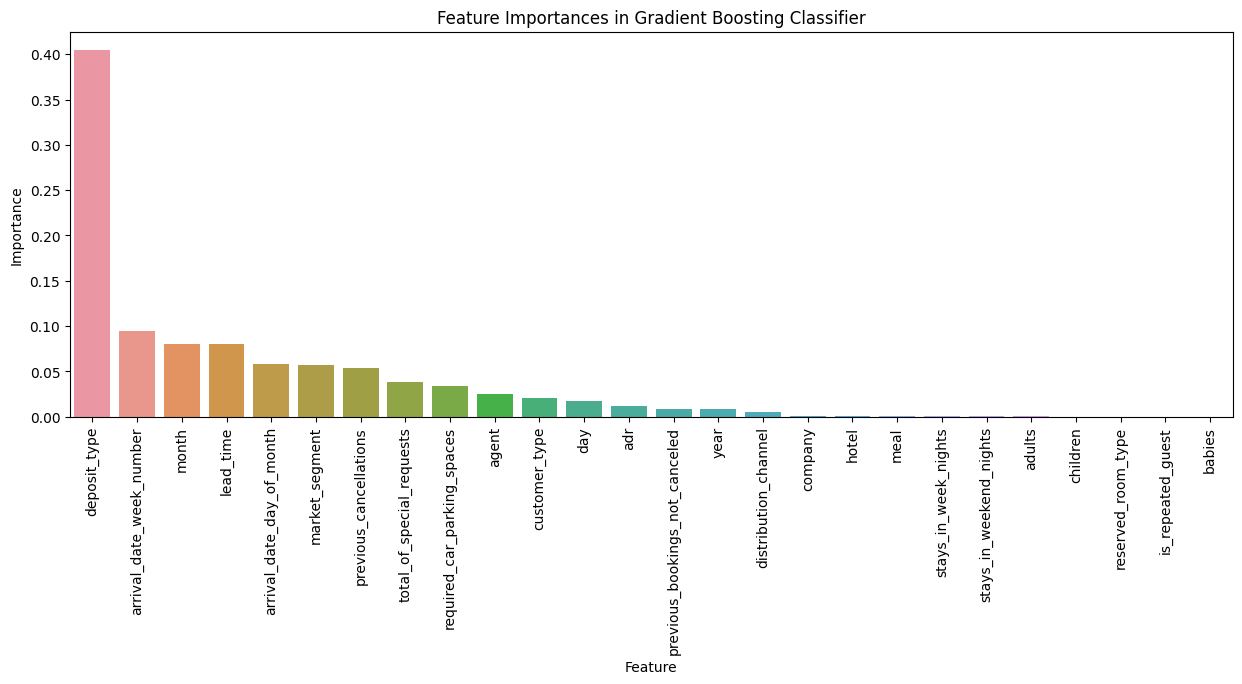

In [ ]:
# Get the feature importances from the Gradient Boosting model
feature_importances = gb.feature_importances_

# Create a DataFrame to store the feature importances and feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by the importance scores
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 5))
sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.title('Feature Importances in Gradient Boosting Classifier')
plt.xticks(rotation=90)
plt.show()

1. deposit_type feature has the highest importance in predicting cancellations, this suggests that whether a customer makes a deposit to guarantee the booking is a critical factor in determining whether they will cancel the booking.

2. "ArrivalDateWeekNumber" has the second highest importance value in the plot of feature importances, this would suggest that the week number of the arrival date is the most important factor in predicting cancellations.

One possible interpretation of this finding is that certain weeks of the year might have a higher likelihood of cancellations than others. For example, if the feature importance analysis reveals that bookings made during holiday weeks (such as Christmas or Easter) have a higher cancellation rate, this could indicate that customers are more likely to cancel their bookings during these periods due to changing travel plans or other reasons.

Another possibility is that the ArrivalDateWeekNumber feature is correlated with other important predictors of cancellations. For instance, certain weeks of the year might correspond to peak travel seasons, which could in turn be associated with higher prices, longer lead times, or other factors that contribute to cancellations.

Regardless of the specific interpretation, if the ArrivalDateWeekNumber feature is found to be the most important predictor of cancellations, this suggests that booking cancellations are strongly associated with the timing of the booking relative to the arrival date. To reduce the cancellation rate, the hotel might consider implementing strategies such as adjusting the pricing or booking policies during high-risk weeks, or targeting marketing campaigns towards customers who are more likely to follow through with their bookings.



4. "lead_time" feature has the fourth highest importance value, this suggests that the
number of days between the booking date and the arrival date is a critical factor in predicting cancellations.




# SVM

In [ ]:
# Instantiate the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test sets
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

# Instantiate the SVM model
svm = LinearSVC()

# Fit the model on the training data
svm.fit(X_train_minmax, y_train)

# Evaluate the model on the test data
y_test_pred = svm.predict(X_test_minmax)
test_accuracy_svc = accuracy_score(y_test, y_test_pred)

# Evaluate the model on the training data
y_train_pred = svm.predict(X_train_minmax)
train_accuracy_svc = accuracy_score(y_train, y_train_pred)

print(f"Test accuracy of the SVM model before GridSearchCV: {test_accuracy_svc:.2f}")
print(f"Train accuracy of the SVM model before GridSearchCV: {train_accuracy_svc:.2f}")

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(svm, param_grid)

# Fit the grid search to the data
grid_search.fit(X_train_minmax, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test data using the best estimator from the grid search
y_test_pred = grid_search.best_estimator_.predict(X_test_minmax)
test_accuracy_svc = accuracy_score(y_test, y_test_pred)

# Evaluate the model on the training data using the best estimator from the grid search
y_train_pred = grid_search.best_estimator_.predict(X_train_minmax)
train_accuracy_svc = accuracy_score(y_train, y_train_pred)

print(f"Test accuracy of the SVM model after GridSearchCV: {test_accuracy_svc:.2f}")
print(f"Train accuracy of the SVM model after GridSearchCV: {train_accuracy_svc:.2f}")

Test accuracy of the SVM model before GridSearchCV: 0.80
Train accuracy of the SVM model before GridSearchCV: 0.81
Best parameters:  {'C': 10}
Best score:  0.8064127524945242
Test accuracy of the SVM model after GridSearchCV: 0.80
Train accuracy of the SVM model after GridSearchCV: 0.81


In [ ]:
# k-fold cross-validation on Support vector machine
# Perform k-fold cross-validation with 5 folds
cv_scores = cross_val_score(svm, X_train_minmax, y_train, cv=5)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", cv_scores)

# Calculate and print the average accuracy across the 5-fold cross-validation
average_accuracy = cv_scores.mean()
print(f"Average accuracy across the 5-fold cross-validation: {average_accuracy:.2f}")

Accuracy scores for each fold: [0.80986858 0.80938184 0.80305427 0.80658311 0.79794354]
Average accuracy across the 5-fold cross-validation: 0.81


In [ ]:
# Create a mesh grid
x_min, x_max = X_train_minmax[:, 0].min() - 1, X_train_minmax[:, 0].max() + 1
y_min, y_max = X_train_minmax[:, 1].min() - 1, X_train_minmax[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# Predict the class for each point in the mesh grid
Z = grid_search.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)

# Plot the training points
plt.scatter(X_train_minmax[:, 0], X_train_minmax[:, 1], c=y_train)
plt.show()

# Performance metrics of three models

In [ ]:
def get_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
    }
    return metrics

def create_metrics_table(models, X_test, y_test):
    metrics = []

    for name, model in models.items():
        y_test_pred = model.predict(X_test)
        model_metrics = get_metrics(y_test, y_test_pred)
        model_metrics["Model"] = name
        metrics.append(model_metrics)

    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index("Model", inplace=True)

    return metrics_df

# Assuming you have already trained your models (svm, gb, log_reg_l1) and have the X_test and y_test data
models = {"SVM": svm, "Gradient Boosting": best_gb, "Logistic Regression": log_reg_l1}
metrics_df = create_metrics_table(models, X_test, y_test)
print(metrics_df)
# The data is imbalanced, gradient boosting with best parameter better for imbalanced dataset as it work by learning a hierachy of if/else
# questions and this can force both classes to be addressed

                     Accuracy  Precision    Recall  F1 Score
Model                                                       
SVM                  0.378989   0.377566  0.998945  0.548006
Gradient Boosting    0.995855   0.998481  0.990507  0.994478
Logistic Regression  0.384952   0.379776  0.998267  0.550226


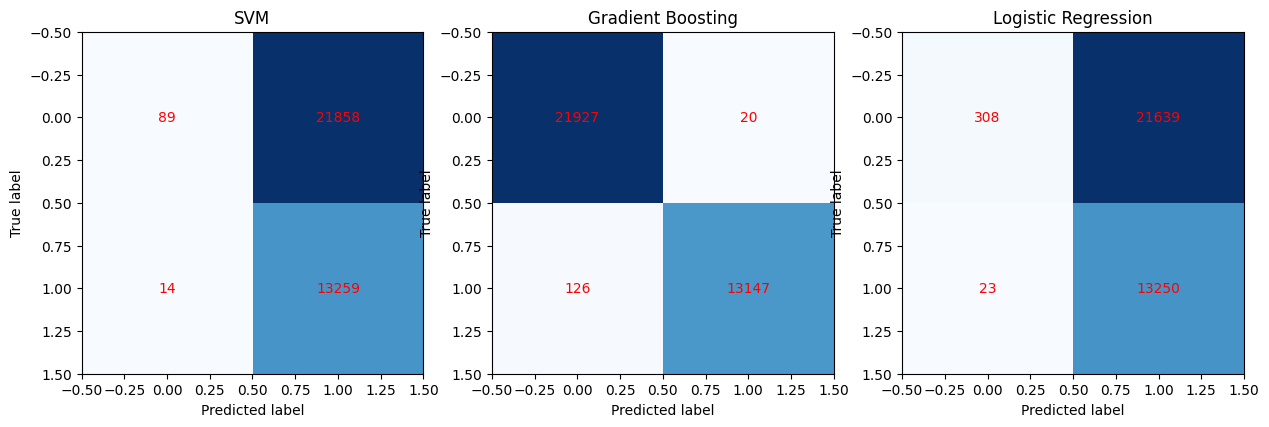

In [ ]:
# Create a dictionary of models
models = {"SVM": svm, "Gradient Boosting": best_gb, "Logistic Regression": log_reg_l1}

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop over the models
for ax, (name, model) in zip(axes, models.items()):
    # Calculate the confusion matrix for the current model
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix as an image
    ax.imshow(cm, cmap="Blues")

    # Add text annotations to display the values in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="red")

    # Set the title and axis labels
    ax.set_title(name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

# Display the resulting plot
plt.show()

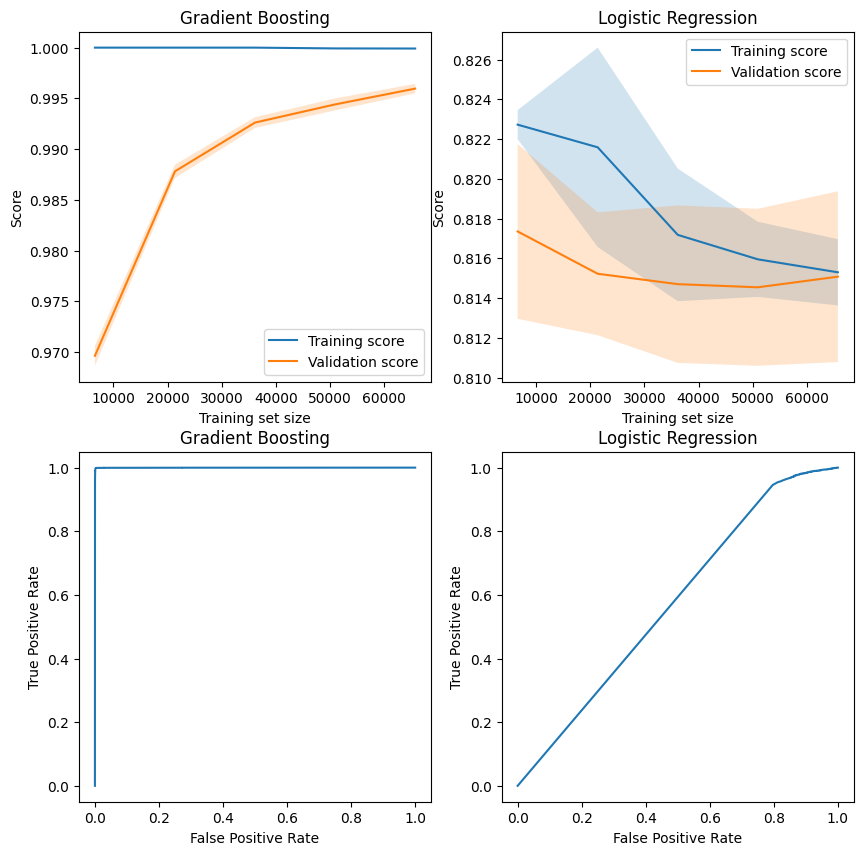

In [ ]:
models = {"Gradient Boosting": best_gb, "Logistic Regression": log_reg_l1}

# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Loop over the models
for i, (name, model) in enumerate(models.items()):
    # Calculate the training and validation scores for different training set sizes
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train)

    # Calculate the mean and standard deviation of the training and validation scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    valid_scores_std = valid_scores.std(axis=1)

    # Plot the learning curve
    ax = axes[0, i]
    ax.plot(train_sizes, train_scores_mean, label="Training score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(train_sizes, valid_scores_mean, label="Validation score")
    ax.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                    valid_scores_mean + valid_scores_std, alpha=0.2)

    # Set the title and axis labels
    ax.set_title(name)
    ax.set_xlabel("Training set size")
    ax.set_ylabel("Score")

    # Add a legend
    ax.legend()

    # Calculate the false positive rate and true positive rate for different decision thresholds
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)

    # Plot the ROC curve
    ax = axes[1,i]
    ax.plot(fpr,tpr,label='ROC Curve')

     # Set the title and axis labels
    ax.set_title(name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

# Display the resulting plot
plt.show()


The training score and validation score of decision tree model are better than logistic regression model.
The training score and validation score of decision tree model goes up untill around 35000 training set size. After 35000 set size, the training score and validation score start to fall. Meanwhile, the gap between two score become much more narrow.
It indicate that the model overfitted in 35000 training set size. And the modal generalize and less likey to overfit.  

For logistic regression model, the training score of the model decrease gradually and the validation score increase slowly. It show that the moedel generalized and less likey to overfit



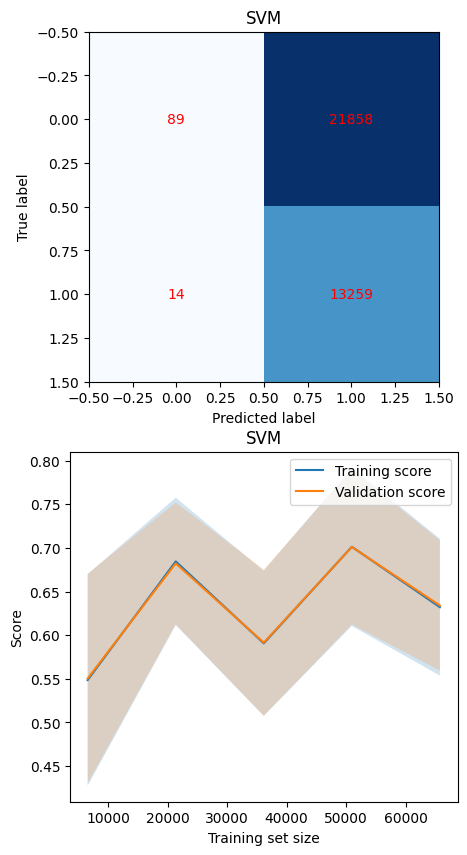

In [ ]:
models = {"SVM": svm}

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

# Loop over the models
for i, (name, model) in enumerate(models.items()):
    # Calculate the confusion matrix for the current model
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix as an image
    ax = axes[0]
    ax.imshow(cm, cmap="Blues")

    # Add text annotations to display the values in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="red")

    # Set the title and axis labels
    ax.set_title(name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Calculate the training and validation scores for different training set sizes
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train)

    # Calculate the mean and standard deviation of the training and validation scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    valid_scores_std = valid_scores.std(axis=1)

    # Plot the learning curve
    ax = axes[1]
    ax.plot(train_sizes, train_scores_mean, label="Training score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(train_sizes, valid_scores_mean, label="Validation score")
    ax.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                    valid_scores_mean + valid_scores_std, alpha=0.2)

    # Set the title and axis labels
    ax.set_title(name)
    ax.set_xlabel("Training set size")
    ax.set_ylabel("Score")

    # Add a legend
    ax.legend()

# Display the resulting plot
plt.show()

# Implication

In [ ]:
####Implication
def predict_one_row(model, X): #Function for interpret the result
        display(X.to_frame().T)
        result = True if (model.predict(X.to_frame().T)[0] == True) else False
        print('Possible Cancel Customer:', result)
        return result

def implication_demo():
    #### take one row in X_test as example
    predict_one_row(best_gb, X_test.iloc[0])
    predict_one_row(best_gb, X_test.iloc[4])

    #### Generate random data to simluate user entry
    new_row_random_gen = pd.Series({
        key: X_test[key].iloc[random.randint(0, X_test.shape[0])] for key in X_test.iloc[0].index
    })
    predict_one_row(best_gb, new_row_random_gen)

implication_demo()


,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day,...,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
106320,1.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,2.0,24.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,140.4,0.0,0.0


Possible Cancel Customer: False


,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day,...,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
1229,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,6.0,18.0,...,0.0,0.0,0.0,0.0,0.0,240.0,0.0,198.0,0.0,0.0


Possible Cancel Customer: True


,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day,...,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,10.0,11.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,99.0,0.0,0.0


Possible Cancel Customer: True
